## Titanic
### Analysis and modeling of the Titanic dataset
This Jupyter notebook analysis and models the famous Titanic dataset using Polar and logistic regression.

This is *not* an attempt to find the best predictive model.

### 1. Preparation

#### Import packages

In [162]:
import os
import numpy as np
import polars as pl
#import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

#### List files and folders

In [163]:
os.listdir()

['README.md', '.gitignore', 'titanic.csv', 'venv', '.git', 'titanic.ipynb']

#### Load dataset

In [164]:
df = pl.read_csv("titanic.csv", separator=",")

df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""


#### Variable definitions (selected variables)

Survived:   1 = Yes,    0 = No

Pclass:     Whether the passenger was a 1st, 2nd or 3rd class passenger (1, 2, 3)

Age:        Age in years

Sex:        Male or female

SibSp:      Number of siblings or Spouse aboard the Titanic

Parch:      Number of parents or children aboard the Titanic

Embarked:	Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Have a look at the columns

In [165]:
df.describe()

statistic,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
str,f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str
"""count""",891.0,891.0,891.0,"""891""","""891""",714.0,891.0,891.0,"""891""",891.0,"""204""","""889"""
"""null_count""",0.0,0.0,0.0,"""0""","""0""",177.0,0.0,0.0,"""0""",0.0,"""687""","""2"""
"""mean""",446.0,0.383838,2.308642,null,null,29.699118,0.523008,0.381594,null,32.204208,null,null
"""std""",257.353842,0.486592,0.836071,null,null,14.526497,1.102743,0.806057,null,49.693429,null,null
"""min""",1.0,0.0,1.0,"""Abbing, Mr. Anthony""","""female""",0.42,0.0,0.0,"""110152""",0.0,"""A10""","""C"""
"""25%""",224.0,0.0,2.0,null,null,20.0,0.0,0.0,null,7.925,null,null
"""50%""",446.0,0.0,3.0,null,null,28.0,0.0,0.0,null,14.4542,null,null
"""75%""",669.0,1.0,3.0,null,null,38.0,1.0,0.0,null,31.0,null,null
"""max""",891.0,1.0,3.0,"""van Melkebeke, Mr. Philemon""","""male""",80.0,8.0,6.0,"""WE/P 5735""",512.3292,"""T""","""S"""


#### Change variables

In [166]:
df = df.filter(pl.col("Embarked").is_not_null())

# Add a column indicating when Age is missing
df = df.with_columns(pl.col("Age").fill_null(0))
#df = df.with_columns(NoAge = pl.lit(np.where(df['Age'] == 0, 1, 0)))
#df = df.with_columns(MaleAge = pl.lit(df['Age'] * np.where(df['Sex'] == 'male', 1, 0)))

df = df.with_columns(pl.col("Embarked").str.replace("C", "Cherbourg", literal=True))
df = df.with_columns(pl.col("Embarked").str.replace("Q", "Queenstown", literal=True))
df = df.with_columns(pl.col("Embarked").str.replace("S", "Southampton", literal=True))

df = df.with_columns(#pl.col("Pclass").cast(pl.String).cast(pl.Categorical),
                     pl.col("Sex").cast(pl.Categorical),
                     pl.col("Embarked").cast(pl.Categorical))

df.head(3)

/var/folders/16/k4p2vb8n4hbf3p7ysr46nvq80000gn/T/ipykernel_12208/995259413.py:12: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = df.with_columns(#pl.col("Pclass").cast(pl.String).cast(pl.Categorical),


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""Southampton"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""Cherbourg"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""Southampton"""


####

#### Encode variables

In [167]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="polars")

df_enc = encoder.fit_transform(df[["Pclass", 'Sex', 'Embarked']])

#df_enc = df_enc.rename(lambda column_name: column_name[1+column_name.find('_'):])

df = pl.concat([df, df_enc], how="horizontal")

df = df.rename({"Pclass": "Class", "Pclass_1": "Class_1", "Pclass_2": "Class_2", "Pclass_3": "Class_3",
                "Sex_male": "Male", "Sex_female": "Female",
                "Embarked_Cherbourg": "Cherbourg", "Embarked_Queenstown": "Queenstown", "Embarked_Southampton": "Southampton"})

df.head(3)

PassengerId,Survived,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class_1,Class_2,Class_3,Female,Male,Cherbourg,Queenstown,Southampton
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,f64,f64,f64,f64,f64,f64,f64,f64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""Southampton""",0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""Cherbourg""",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""Southampton""",0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


#### Lists of independent variables 

In [168]:
#x_cols1 corresponds to an intercept-only model
x_cols2 = ['Class']
x_cols3 = x_cols2 + ['Male', 'Age']
x_cols4 = x_cols3 + ["Cherbourg", "Queenstown"] # "Southampton"

#### Prepare variables for modeling

In [169]:
y = df['Survived'].to_numpy().ravel()
x2 = df[x_cols2].to_numpy()
x3 = df[x_cols3].to_numpy()
x4 = df[x_cols4].to_numpy()

survival_prob = np.mean(y)

#### Correlation

In [170]:
np.tril(np.round(np.corrcoef(np.transpose(df[x_cols4])), 2))

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.13,  1.  ,  0.  ,  0.  ,  0.  ],
       [-0.36,  0.03,  1.  ,  0.  ,  0.  ],
       [-0.25, -0.08,  0.  ,  1.  ,  0.  ],
       [ 0.22, -0.08, -0.24, -0.15,  1.  ]])

### 2. Estimation

##### Model 1
A simple setup (simply to ensure that the mean value is estimated correctly):
* Use only the intercept
* Don't use a penalty term

In [171]:
model1 = LogisticRegression(penalty=None, fit_intercept=False).fit(np.full((df.shape[0], 1), 1), y)
print("Mean survival rate: {:.1f}".format(survival_prob*100))
print("Predicted mean survival rate: {:.1f}".format(1/(1+np.exp(-model1.coef_))[0][0]*100))

Mean survival rate: 38.2
Predicted mean survival rate: 38.2


##### Model 2
Setup:
* Use the variables in 'x_cols2'
* Don't use a penalty term

In [172]:
model2 = LogisticRegression(penalty=None, fit_intercept=True).fit(x2, y)
print("Model intercept:", model2.intercept_)
print("Model coefficients:", model2.coef_)

Model intercept: [1.42829871]
Model coefficients: [[-0.84349355]]


##### Model 3
Setup:
* Use the variables in 'x_cols3'
* Don't use a penalty term

In [173]:
model3 = LogisticRegression(penalty=None, fit_intercept=True).fit(x3, y)
print("Model intercept:", model3.intercept_)
print("Model coefficients:", model3.coef_)

Model intercept: [3.95441553]
Model coefficients: [[-1.09200821 -2.62575288 -0.01591818]]


##### Model 4
Setup:
* Use the variables in 'x_cols4'
* Don't use a penalty term

In [174]:
model4 = LogisticRegression(penalty=None, fit_intercept=True).fit(x4, y)
print("Model intercept:", model4.intercept_)
print("Model coefficients:", model4.coef_)

Model intercept: [3.69983747]
Model coefficients: [[-1.05105643 -2.61368299 -0.01425755  0.48211442  0.24277648]]


In [175]:
nmodels = 4

#### Fitted values

In [176]:
y_fit = np.concatenate((
                        np.full(df.shape[0], 1) if survival_prob >= 0.5 else np.full(df.shape[0], 0).reshape(-1, 1),
                        model2.predict(x2).reshape(-1, 1),
                        model3.predict(x3).reshape(-1, 1),
                        model4.predict(x4).reshape(-1, 1)
                        ), axis=1)
y_fit.shape

(889, 4)

#### Probabilities

In [177]:
y_prob = np.concatenate((
                         np.full(df.shape[0], survival_prob).reshape(-1, 1),
                         model2.predict_proba(x2)[:, 1].reshape(-1, 1),
                         model3.predict_proba(x3)[:, 1].reshape(-1, 1),
                         model4.predict_proba(x4)[:, 1].reshape(-1, 1)
                         ), axis=1)
y_prob.shape

(889, 4)

### 3. Evaluation

##### Negative log-loss

<BarContainer object of 4 artists>

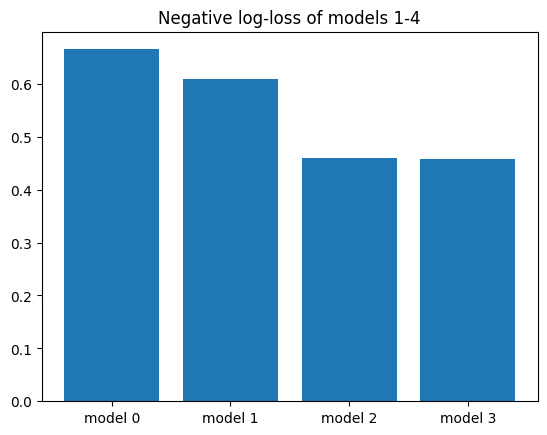

In [178]:
ll = [log_loss(y, y_prob[:, i]) for i in range(nmodels)]

plt.title("Negative log-loss of models 1-{}".format(nmodels))
plt.bar(["model " + str(i) for i in range(nmodels)], height=ll)

<BarContainer object of 4 artists>

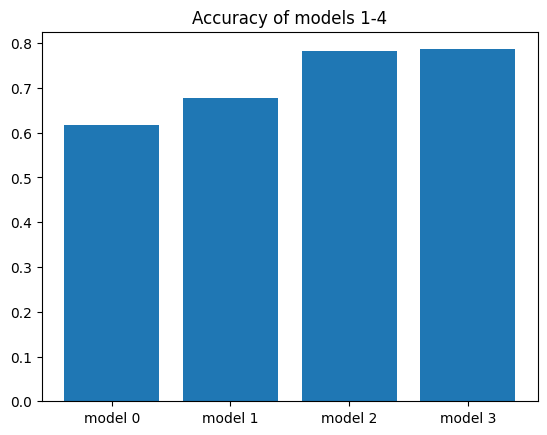

In [179]:
vals = [accuracy_score(y, y_fit[:, i]) for i in range(nmodels)]

plt.title("Accuracy of models 1-{}".format(nmodels))
plt.bar(["model " + str(i) for i in range(nmodels)], height=vals)

#### Plot survival probabilities
##### Model 3

(0.0, 100.0)

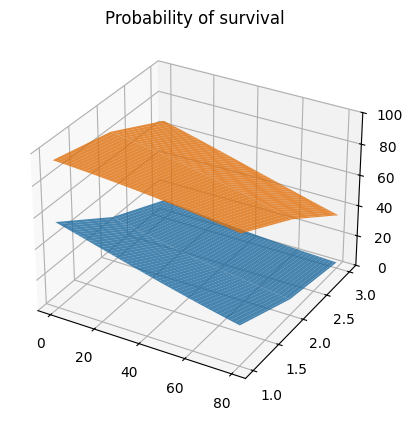

In [180]:
x_age   = np.repeat(np.linspace(0, 80, 100), 3).reshape(-1, 1)
x_class = np.tile([1, 2, 3], 100).reshape(-1, 1)
x_male  = np.repeat([1], 300).reshape(-1, 1)

x_plot = np.concatenate((x_class, x_male, x_age), axis=1)
y_plot = model3.predict_proba(x_plot)[:, 1]*100

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_title("Probability of survival")
ax.plot_surface(x_age.reshape(100, 3), x_class.reshape(100, 3), y_plot.reshape(100, 3), alpha=0.8)

x_male = np.repeat([0], 300).reshape(-1, 1)

x_plot = np.concatenate((x_class, x_male, x_age), axis=1)
y_plot = model3.predict_proba(x_plot)[:, 1]*100

ax.plot_surface(x_age.reshape(100, 3), x_class.reshape(100, 3), y_plot.reshape(100, 3), alpha=0.8)
ax.set_zlim((0, 100))

#### Plot odds ratio
The odds of survival for a one-unit change in the variable.

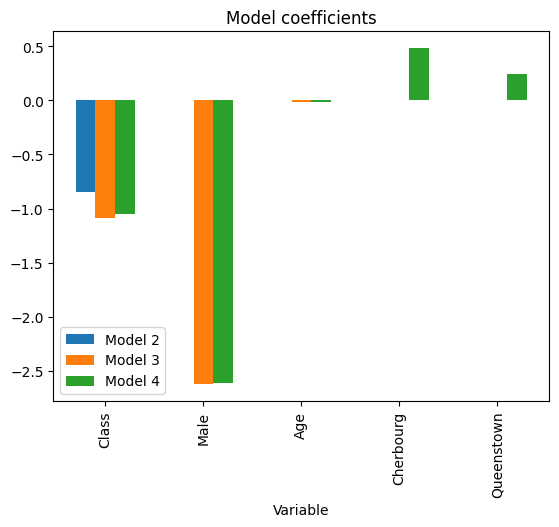

In [181]:
b2 = model2.coef_.shape[1]
b3 = model3.coef_.shape[1]
b4 = model4.coef_.shape[1]

c2 = np.concatenate((model2.coef_.reshape(b2, 1), np.full((b4-b2, 1), np.nan)), axis=0)
c3 = np.concatenate((model3.coef_.reshape(b3, 1), np.full((b4-b3, 1), np.nan)), axis=0)
c4 = model4.coef_.reshape(b4, 1)

#vals = np.exp(np.concatenate((c2, c3, c4), axis=1))
vals = np.concatenate((c2, c3, c4), axis=1)
x = np.arange(vals.shape[0])

for i in range(1, nmodels):
    plt.bar(x+(i-nmodels/2)/(1+nmodels), vals[:, i-1], 0.2)

plt.title("Model coefficients")
plt.xticks(x, x_cols4, rotation = 90)
plt.xlabel("Variable")
plt.legend(["Model " + str(i) for i in range(2, nmodels+2)])


### 4. Cross-validation

So far the models have been fitted to the full dataset, ignoring any overfitting issues and the statistical significance of the variables. Eyeballing the log-loss plot, there is no material improvement from going to model 2 to model 3 (or model 4).

#### K-Fold cross-validation

In [182]:
kn = 20
kf = KFold(n_splits=kn)

LL = np.zeros((kn, nmodels))
AS = np.zeros((kn, nmodels))

coefs = {
         "model1": np.zeros((kn, model1.coef_.shape[1])),
         "model2": np.zeros((kn, model2.coef_.shape[1])),
         "model3": np.zeros((kn, model3.coef_.shape[1])),
         "model4": np.zeros((kn, model4.coef_.shape[1]))
         }

for i, (train_rows, test_rows) in enumerate(kf.split(x4)):
    #print("Fold", i+1, "of", kn)
    x1 = np.full((df.shape[0], 1), 1)

    model1k = LogisticRegression(penalty=None, fit_intercept=True).fit(x1[train_rows, :], y[train_rows])
    model2k = LogisticRegression(penalty=None, fit_intercept=True).fit(x2[train_rows, :], y[train_rows])
    model3k = LogisticRegression(penalty=None, fit_intercept=True).fit(x3[train_rows, :], y[train_rows])
    model4k = LogisticRegression(penalty=None, fit_intercept=True).fit(x4[train_rows, :], y[train_rows])
    
    coefs["model1"][i, :] = model1k.coef_.ravel()
    coefs["model2"][i, :] = model2k.coef_.ravel()
    coefs["model3"][i, :] = model3k.coef_.ravel()
    coefs["model4"][i, :] = model4k.coef_.ravel()

    AS[i, 0] = accuracy_score(y[train_rows], model1k.predict(x1[train_rows, :]))
    AS[i, 1] = accuracy_score(y[train_rows], model2k.predict(x2[train_rows, :]))
    AS[i, 2] = accuracy_score(y[train_rows], model3k.predict(x3[train_rows, :]))
    AS[i, 3] = accuracy_score(y[train_rows], model4k.predict(x4[train_rows, :]))

    LL[i, 0] = log_loss(y[train_rows], model1k.predict_proba(x1[train_rows, :])[:, 1].reshape(-1, 1))
    LL[i, 1] = log_loss(y[train_rows], model2k.predict_proba(x2[train_rows, :])[:, 1].reshape(-1, 1))
    LL[i, 2] = log_loss(y[train_rows], model3k.predict_proba(x3[train_rows, :])[:, 1].reshape(-1, 1))
    LL[i, 3] = log_loss(y[train_rows], model4k.predict_proba(x4[train_rows, :])[:, 1].reshape(-1, 1))

ASn = [[AS[i, j]*100 - AS[i, 0]*100 for i in range(kn)] for j in range(1, nmodels)]
LLn = [[-(LL[i, j]/LL[i, 0]*100 - 100) for i in range(kn)] for j in range(1, nmodels)]

#### Plot boxplot of accuracies and log-losses
Relative to intercept-only model

Text(0, 0.5, 'Percent / Percentage point')

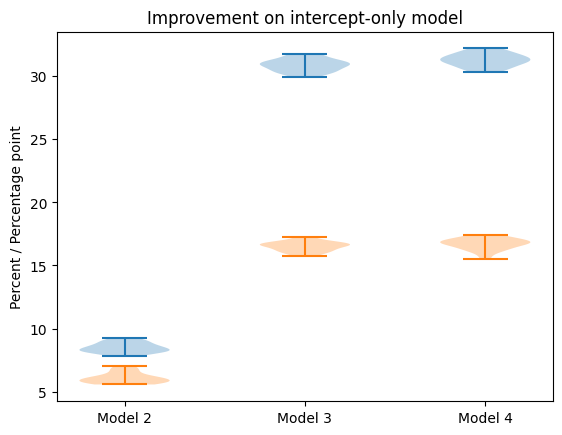

In [183]:
plt.violinplot(LLn)
plt.violinplot(ASn)
plt.xticks(range(1, nmodels), ["Model " + str(i+1) for i in range(1, nmodels)])
plt.title("Improvement on intercept-only model")
plt.ylabel("Percent / Percentage point")

#### Plot boxplot of model 4 coefficients

In [184]:
coefs["model4"][:, 2]

array([-0.01345898, -0.01389037, -0.01247459, -0.01385241, -0.0147304 ,
       -0.01406749, -0.01582706, -0.01366838, -0.01433526, -0.01445246,
       -0.01521616, -0.01521909, -0.0165862 , -0.01456665, -0.01510043,
       -0.01315044, -0.01234613, -0.01452198, -0.0136203 , -0.01429794])

([<matplotlib.axis.XTick at 0x147cbc320>,
 [Text(1, 0, 'Class'),
  Text(2, 0, 'Male'),
  Text(3, 0, 'Age'),
  Text(4, 0, 'Cherbourg'),
  Text(5, 0, 'Queenstown')])

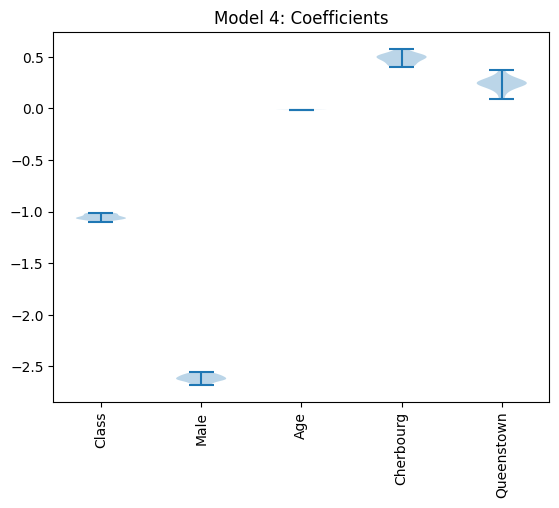

In [185]:
plt.violinplot(coefs['model4'])
plt.title("Model 4: Coefficients")
plt.xticks(np.arange(len(x_cols4))+1, x_cols4, rotation=90)